# SVCCA for weekly forecast with multihead CNN model

In [13]:
import os, sys
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
import cca_core
%matplotlib inline


In [2]:
# Rank Correlation of SVCCA mean model correlation (net similarity) and Transferability (Transfer Performance increase)
def rank_pearson_corr(transferability, svcca_corr_all):
    # spearman roh rank-correlation
    spearman_corr, spearman_pvalue = stats.spearmanr(transferability, svcca_corr_all)
    print("Spearman Correlation:", spearman_corr)
    print("Spearman p_value:", spearman_pvalue)
    print("")
    # kendall tau rank-correlation
    kendall_tau, kendall_p_value = stats.kendalltau(transferability, svcca_corr_all)
    print("Kendall Correlation:", kendall_tau)
    print("Kendall p_value:", kendall_p_value)
    print("")
    # pearson linear correlation for comparison
    pearson_corr, pearson_pvalue = stats.pearsonr(transferability, svcca_corr_all)
    print("Pearson Correlation:", pearson_corr)
    print("Pearson p_value:", pearson_pvalue)

In [3]:
# load python file to compare SVCCA results with results saved in csv / sanity check
import SVCCA_weekly

m1_x1/m1_x1 Mean Model Correlation: 0.9884350314409864
m1_x1/m2_x1 Mean Model Correlation: 0.7771485898526138
m1_x1/m3_x1 Mean Model Correlation: 0.8218706525535338
m1_x1/m4_x1 Mean Model Correlation: 0.7407753921416145
m1_x1/m5_x1 Mean Model Correlation: 0.7239123714734335
m1_x1/m6_x1 Mean Model Correlation: 0.7199248224828523
m2_x2/m1_x2 Mean Model Correlation: 0.7740242962415331
m2_x2/m2_x2 Mean Model Correlation: 0.9819694799442691
m2_x2/m3_x2 Mean Model Correlation: 0.7778474201122719
m2_x2/m4_x2 Mean Model Correlation: 0.7859456904356878
m2_x2/m5_x2 Mean Model Correlation: 0.72914693085842
m2_x2/m6_x2 Mean Model Correlation: 0.7292970114091916
m3_x3/m1_x3 Mean Model Correlation: 0.8291519628202048
m3_x3/m2_x3 Mean Model Correlation: 0.7864854465365587
m3_x3/m3_x3 Mean Model Correlation: 0.9911710570283949
m3_x3/m4_x3 Mean Model Correlation: 0.7633277354108449
m3_x3/m5_x3 Mean Model Correlation: 0.7631139848712603
m3_x3/m6_x3 Mean Model Correlation: 0.8110469229112796
m4_x4/m1_x4 

In [4]:
net_similarities = pd.read_csv('../temp/net_similarity_weekly.csv')

# net_similarities visualization
print("Net Similarity:")
cm = sns.light_palette("green", as_cmap=True)
net_sim_visual = net_similarities.style.background_gradient(cmap=cm)
net_sim_visual

Net Similarity:


,0,1,2,3,4,5
0,0.988435,0.774024,0.829152,0.744282,0.743305,0.732103
1,0.777149,0.981969,0.786485,0.786807,0.733647,0.739434
2,0.821871,0.777847,0.991171,0.763334,0.766677,0.803229
3,0.740775,0.785946,0.763328,0.980046,0.731813,0.787813
4,0.723912,0.729147,0.763114,0.728771,0.989469,0.835934
5,0.719925,0.729297,0.811047,0.78916,0.831604,0.994235


# Comparison with transferability 

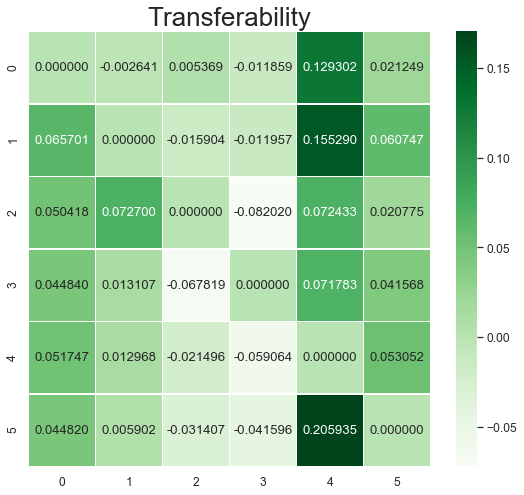

In [5]:
transferability = [
    [0,-0.0026408,0.0053692,-0.0118591,0.1293025,0.0212494],
    [0.0657007,0,-0.0159039,-0.0119574,0.1552900,0.0607466],
    [0.0504179,0.0727003,0,-0.0820202,0.0724330,0.0207745],
    [0.0448396,0.0131069,-0.0678191,0,0.0717826,0.0415678],
    [0.0517473,0.0129677,-0.0214962,-0.0590644,0,0.0530523],
    [0.0448200,0.0059016,-0.0314071,-0.0415958,0.2059353,0]
]
transferability = pd.DataFrame(transferability)
# transferability
#sns.heatmap(transferability, cmap='Greens', annot=True)
sns.set(font_scale=1.1)

f, ax = plt.subplots(figsize=(9, 8))
ax.set_title('Transferability', fontsize=26)
sns.heatmap(transferability, annot=True, fmt="f", linewidths=.5, ax=ax,robust=True, cmap='Greens') #RdBu_r
plt.show()

In [6]:
# flatten dataframes to array for correlation calculation

# Net Similarity data frame
net_sim_array = np.ravel(net_similarities.values)

# Transferability data frame
transfer_array = np.ravel(transferability.values)

In [7]:
# Rank (Spearman) and Pearson Correlation 
# without transferability=0 and net_similarity=1 for all branches / diagonal in matrix
print('Rank and Pearson Correlation without transferability=0 and net_similarity=1 for all branches')
print("")

relevant_indices = [1,2,3,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,22,23,24,25,26,27,29,30,31,32,33,34]
# len(transfer_array[relevant_indices])
#rank_pearson_corr(transfer_array, net_sim_array)
rank_pearson_corr(transfer_array[relevant_indices], net_sim_array[relevant_indices])

Rank and Pearson Correlation without transferability=0 and net_similarity=1 for all branches

Spearman Correlation: -0.04204671857619577
Spearman p_value: 0.8253954034384129

Kendall Correlation: -0.02528735632183908
Kendall p_value: 0.8596481443908845

Pearson Correlation: 0.04757521346362088
Pearson p_value: 0.8028588696103411


p-value to test for non-correlation:
 
The two-sided p-value for a hypothesis test whose null hypothesis is that two sets of data are uncorrelated, has same dimension as rho.


p-value ≤ α: The correlation is statistically significant (usually α = 0.05 or 0.01)

If the p-value is less than or equal to the significance level, then you can conclude that the correlation is different from 0.

p-value >> 0.05 or 0.01, H0 can't be disproved.

In [8]:
# sanity check for correlation example

a = [1,2,3,4,5,6]
b = [2,4,6,8,10,12]

rank_pearson_corr(a,b)

Spearman Correlation: 1.0
Spearman p_value: 0.0

Kendall Correlation: 0.9999999999999999
Kendall p_value: 0.002777777777777778

Pearson Correlation: 1.0
Pearson p_value: 0.0


In [9]:
c = [4,1,5,-1,-10,14]
rank_pearson_corr(a,c)

Spearman Correlation: 0.028571428571428574
Spearman p_value: 0.9571545189504373

Kendall Correlation: -0.06666666666666665
Kendall p_value: 1.0

Pearson Correlation: 0.07457270080840457
Pearson p_value: 0.8883483014522222


# head-wise comparison of net similarity and transferability

In [34]:
# methods for calculating SVCCA for all branches

def SVCCA(activations1, activations2, layer_number):
    # SVCCA different x
    # print("Results using SVCCA keeping 30 dims")
    # load activations
    acts1 = np.genfromtxt(activations1 + str(layer_number) + '.csv', delimiter=',')
    acts2 = np.genfromtxt(activations2 + str(layer_number) + '.csv', delimiter=',')

    # Mean subtract activations
    cacts1 = acts1 - np.mean(acts1, axis=0, keepdims=True)
    cacts2 = acts2 - np.mean(acts2, axis=0, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)

    svacts1 = np.dot(s1[:30] * np.eye(30), V1[:30])  # default: np.dot(s1[:20]*np.eye(20), V1[:20]), 49
    # can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
    svacts2 = np.dot(s2[:30] * np.eye(30), V2[:30])  # default: np.dot(s2[:20]*np.eye(20), V2[:20]), 49
    # can also compute as svacts1 = np.dot(U2.T[:20], cacts2)

    svcca_results = cca_core.get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)  # 1e-10
    # print("Layer Number:", layer_number)
    # print("SVCCA Correlation Coefficient:", np.mean(svcca_results["cca_coef1"]))
    return np.mean(svcca_results["cca_coef1"])  # , acts1, cacts1, U1, s1, V1, svacts1


def calaculate_mean_model_correlation(activation1, activation2, conv_layers):
    # list for storing layer correlations
    layer_corr = []
    # calculate and save SVCCA correlation between all layers of two base models
    for conv in conv_layers:
        corr = SVCCA(activation1, activation2, conv)  # , acts1, cacts1, U1, s1, V1, svacts1
        layer_corr.append(corr)
    # calculate mean model correlation of stored layer correlation
    mean_model_corr = np.mean(layer_corr)
    # print(activation1[-13:-8] + activation2[-14:-8] + " Mean Model Correlation:", mean_model_corr)
    return mean_model_corr


def calculate_SVCCA_for_all_branches(conv_layers):
    # list of target branch activations on target branch input data
    act_targets = ['activations/weekly/m1_x1_weekly/',
                   'activations/weekly/m2_x2_weekly/',
                   'activations/weekly/m3_x3_weekly/',
                   'activations/weekly/m4_x4_weekly/',
                   'activations/weekly/m5_x5_weekly/',
                   'activations/weekly/m6_x6_weekly/']

    # list to store mean model correlations
    model_correlations = []

    # list of activations on target branch input data
    act1_list = ['activations/weekly/m1_x1_weekly/',
                 'activations/weekly/m2_x1_weekly/',
                 'activations/weekly/m3_x1_weekly/',
                 'activations/weekly/m4_x1_weekly/',
                 'activations/weekly/m5_x1_weekly/',
                 'activations/weekly/m6_x1_weekly/']

    for act1 in act1_list:
        cor1 = calaculate_mean_model_correlation(act_targets[0], act1, conv_layers)
        model_correlations.append(cor1)

    act2_list = ['activations/weekly/m1_x2_weekly/',
                 'activations/weekly/m2_x2_weekly/',
                 'activations/weekly/m3_x2_weekly/',
                 'activations/weekly/m4_x2_weekly/',
                 'activations/weekly/m5_x2_weekly/',
                 'activations/weekly/m6_x2_weekly/']

    for act2 in act2_list:
        cor2 = calaculate_mean_model_correlation(act_targets[1], act2, conv_layers)
        model_correlations.append(cor2)

    act3_list = ['activations/weekly/m1_x3_weekly/',
                 'activations/weekly/m2_x3_weekly/',
                 'activations/weekly/m3_x3_weekly/',
                 'activations/weekly/m4_x3_weekly/',
                 'activations/weekly/m5_x3_weekly/',
                 'activations/weekly/m6_x3_weekly/']

    for act3 in act3_list:
        cor3 = calaculate_mean_model_correlation(act_targets[2], act3, conv_layers)
        model_correlations.append(cor3)

    act4_list = ['activations/weekly/m1_x4_weekly/',
                 'activations/weekly/m2_x4_weekly/',
                 'activations/weekly/m3_x4_weekly/',
                 'activations/weekly/m4_x4_weekly/',
                 'activations/weekly/m5_x4_weekly/',
                 'activations/weekly/m6_x4_weekly/']

    for act4 in act4_list:
        cor4 = calaculate_mean_model_correlation(act_targets[3], act4, conv_layers)
        model_correlations.append(cor4)

    act5_list = ['activations/weekly/m1_x5_weekly/',
                 'activations/weekly/m2_x5_weekly/',
                 'activations/weekly/m3_x5_weekly/',
                 'activations/weekly/m4_x5_weekly/',
                 'activations/weekly/m5_x5_weekly/',
                 'activations/weekly/m6_x5_weekly/']

    for act5 in act5_list:
        cor5 = calaculate_mean_model_correlation(act_targets[4], act5, conv_layers)
        model_correlations.append(cor5)

    act6_list = ['activations/weekly/m1_x6_weekly/',
                 'activations/weekly/m2_x6_weekly/',
                 'activations/weekly/m3_x6_weekly/',
                 'activations/weekly/m4_x6_weekly/',
                 'activations/weekly/m5_x6_weekly/',
                 'activations/weekly/m6_x6_weekly/']

    for act6 in act6_list:
        cor6 = calaculate_mean_model_correlation(act_targets[5], act6, conv_layers)
        model_correlations.append(cor6)

    # transform into array and split it into array of 6
    model_correlations_array = np.array(model_correlations)
    model_correlations_array = np.split(model_correlations_array, 6)
    # transform into data frame
    model_correlations_df = pd.DataFrame(model_correlations_array)
    # restructure data frame
    model_correlations_df = model_correlations_df.T
    return model_correlations_df


In [40]:
# to check if we select the right layers of head_1 we load a example CNN model and check the enumeration of layers
from keras.models import load_model
example_model = load_model('../models/pretrained/branch1_cnn_weekly.h5')
print(example_model.layers[4].name)
print(example_model.layers[8].name)

conv1d_1
conv1d_2


# head 1 (revenue)

In [66]:
# Calaculate net similarity just for the first head of CNN model (revenue head) which consists of layer 4 and 8
head_1_layers = [4, 8]
head_1_net_sim = calculate_SVCCA_for_all_branches(head_1_layers)
head_1_visual = head1_net_sim.style.background_gradient(cmap=cm)
head_1_visual

,0,1,2,3,4,5
0,0.999833,0.949699,0.984262,0.964156,0.989365,0.933798
1,0.962197,0.999931,0.984312,0.982985,0.989648,0.980645
2,0.955137,0.94976,0.999973,0.98436,0.999947,0.953087
3,0.95013,0.979538,0.984334,0.999999,0.976765,0.977382
4,0.911792,0.971647,0.985694,0.964595,0.999909,0.98938
5,0.885084,0.940096,0.98436,0.982769,0.972061,0.999946


The convolutional layers of head_1 (revenue) are very similar! Mean model correlation > 0.9

In [67]:
# flatten data frame
head_1_net_sim_array = np.ravel(head_1_net_sim.values)

# calculate correlation between net similarity of head 1 and transferability
rank_pearson_corr(head_1_net_sim_array[relevant_indices], transfer_array[relevant_indices])

Spearman Correlation: -0.07942157953281423
Spearman p_value: 0.6765425401795025

Kendall Correlation: -0.0942528735632184
Kendall p_value: 0.4787611106371266

Pearson Correlation: -0.04337511040109273
Pearson p_value: 0.8199671637125812


# head 2 (month)

In [68]:
# Calaculate net similarity just for the first head of CNN model (month head) which consists of layer 5 and 9
head_2_layers = [5, 9]
head_2_net_sim = calculate_SVCCA_for_all_branches(head_2_layers)
head_2_visual = plot_net_sim(head2_net_sim)
head_2_visual

,0,1,2,3,4,5
0,0.985845,0.774748,0.88207,0.734751,0.83947,0.789332
1,0.774748,0.985449,0.789096,0.854016,0.724772,0.737716
2,0.88207,0.789096,0.995843,0.800877,0.85053,0.973128
3,0.734751,0.854016,0.800877,0.993644,0.655413,0.812415
4,0.83947,0.724772,0.85053,0.655413,0.98787,0.849573
5,0.789332,0.737716,0.973128,0.812415,0.849573,0.997077


Head 2 (month) of the models differs and shows a symetric behaviour in the matrix.

In [69]:
# flatten data frame
head_2_net_sim_array = np.ravel(head_2_net_sim.values)

# calculate correlation between net similarity of head 2 and transferability
rank_pearson_corr(head_2_net_sim_array[relevant_indices], transfer_array[relevant_indices])

Spearman Correlation: -0.08655022859208256
Spearman p_value: 0.64927700419945

Kendall Correlation: -0.05983893490193132
Kendall p_value: 0.6426902687906926

Pearson Correlation: -0.017101454576447985
Pearson p_value: 0.9285297731912872


# head 3 (weekday)

In [70]:
# Calaculate net similarity just for the third head of CNN model (weekday head) which consists of layer 6 and 10
head_3_layers = [6, 10]
head_3_net_sim = calculate_SVCCA_for_all_branches(head_3_layers)
head_3_visual = plot_net_sim(head_3_net_sim)
head_3_visual

,0,1,2,3,4,5
0,0.999918,0.646256,0.695651,0.627415,0.566781,0.552342
1,0.646256,0.998053,0.675756,0.576452,0.495688,0.544431
2,0.695651,0.675756,0.999773,0.59078,0.582828,0.601886
3,0.627415,0.576452,0.59078,0.999996,0.577848,0.630192
4,0.566781,0.495688,0.582828,0.577848,0.999983,0.685362
5,0.552342,0.544431,0.601886,0.630192,0.685362,0.999969


The convolutional layers of Head_3 (weekday) have a symmetric relationship in the matrix.

In [71]:
# flatten data frame
head_3_net_sim_array = np.ravel(head_3_net_sim.values)

# calculate correlation between net similarity of head 3 and transferability
rank_pearson_corr(head_3_net_sim_array[relevant_indices], transfer_array[relevant_indices])

Spearman Correlation: -0.039866394429099304
Spearman p_value: 0.8343219340381155

Kendall Correlation: -0.01162869315077414
Kendall p_value: 0.9288057725390256

Pearson Correlation: 0.024548810698185014
Pearson p_value: 0.8975434882362932


# head 4 (year)

In [72]:
# Calaculate net similarity just for the fourth head of CNN model (year) which consists of layer 7 and 11
head_4_layers = [7, 11]
head_4_net_sim = calculate_SVCCA_for_all_branches(head_4_layers)
head_4_visual = plot_net_sim(head_4_net_sim)
head_4_visual

,0,1,2,3,4,5
0,0.968144,0.725394,0.754625,0.650805,0.577606,0.652942
1,0.725394,0.944445,0.696778,0.733777,0.724482,0.694946
2,0.754625,0.696778,0.969096,0.67732,0.633404,0.684813
3,0.650805,0.733777,0.67732,0.926544,0.717228,0.731262
4,0.577606,0.724482,0.633404,0.717228,0.970114,0.81942
5,0.652942,0.694946,0.684813,0.731262,0.81942,0.979946


Net similarity for Head 4 (year) also shows a symetric relationship in the matrix.

In [73]:
# flatten data frame
head_4_net_sim_array = np.ravel(head_4_net_sim.values)

# calculate correlation between net similarity of head 4 and transferability
rank_pearson_corr(head_4_net_sim_array[relevant_indices], transfer_array[relevant_indices])

Spearman Correlation: 0.057651650551521286
Spearman p_value: 0.76219073463037

Kendall Correlation: 0.04161919241438187
Kendall p_value: 0.7479115177038401

Pearson Correlation: 0.13724328853379592
Pearson p_value: 0.46955450728662695


Overall there is no significant correlation between the net similarity of the distinct heads and the transfer performance delta

# Row-wise comparison of net similarity and transferability

# row 1 (layer 4, 5, 6, 7)

In [74]:
# Calaculate net similarity just for the first row which consists of layer 4, 5, 6, 7
row_1_layers = [4, 5, 6, 7]
row_1_net_sim = calculate_SVCCA_for_all_branches(row_1_layers)
row_1_visual = plot_net_sim(row_1_net_sim)
row_1_visual

,0,1,2,3,4,5
0,0.988964,0.806376,0.846192,0.798947,0.844959,0.767134
1,0.813291,0.976894,0.800623,0.804637,0.753214,0.733392
2,0.831624,0.783342,0.986164,0.817634,0.825084,0.874732
3,0.79168,0.801705,0.817592,0.979508,0.789758,0.840974
4,0.810192,0.739066,0.82509,0.789309,0.991517,0.880908
5,0.767212,0.731318,0.898181,0.852117,0.884005,0.992467


In [75]:
# flatten data frame
row_1_net_sim_array = np.ravel(row_1_net_sim.values)

# calculate correlation between net similarity of convolutional row 1 and transferability
rank_pearson_corr(row_1_net_sim_array[relevant_indices], transfer_array[relevant_indices])

Spearman Correlation: -0.08164627363737487
Spearman p_value: 0.6679884442895885

Kendall Correlation: -0.04827586206896552
Kendall p_value: 0.7235302654564068

Pearson Correlation: 0.02206511335158322
Pearson p_value: 0.907863266105701


# row 2 (layers 8, 9, 10, 11)

In [80]:
# Calaculate net similarity just for the first row which consists of layer 8, 9, 10, 11
row_2_layers = [8, 9, 10, 11]
row_2_net_sim = calculate_SVCCA_for_all_branches(row_2_layers)
row_2_visual = plot_net_sim(row_2_net_sim)
row_2_visual

,0,1,2,3,4,5
0,0.987906,0.741672,0.812112,0.689616,0.641652,0.697073
1,0.741006,0.987045,0.772347,0.768978,0.714081,0.745477
2,0.812117,0.772353,0.996178,0.709034,0.708271,0.731726
3,0.689871,0.770186,0.709063,0.980583,0.673868,0.734652
4,0.637633,0.719228,0.701138,0.668233,0.987421,0.790959
5,0.672638,0.727276,0.723913,0.726203,0.779202,0.996002


In [81]:
# flatten data frame
row_2_net_sim_array = np.ravel(row_2_net_sim.values)

# calculate correlation between net similarity of convolutional row 2 and transferability
rank_pearson_corr(row_2_net_sim_array[relevant_indices], transfer_array[relevant_indices])

Spearman Correlation: 0.07675194660734148
Spearman p_value: 0.6868596934199

Kendall Correlation: 0.05287356321839081
Kendall p_value: 0.6971651256176505

Pearson Correlation: 0.05245775563349917
Pearson p_value: 0.7830829753413892


Overall there is no significant correlation between the net similarity of the two rows of the CNN models and the transfer performance delta
